# Second Step: Improving Models Systematically with Random Search
Trying to manually find the right hyperparameters for a neural network is very difficult. Often you don't know or understand the real influences in the system that push it to be greater or worse. So we can instead work systematically to try and find a better way. There are two main ways to run trial and error programmatically with hyperparameters:
1. **Grid Search** - try every single combination of hyperparameters until you find the best one
2. **Random Search** - randomly choosing combinations of hyperparameters and seeing which one is the best combination.

In this notebook we will do **Random Search**. After, we can plot each hyperparameter against the Loss of the model to understand if there are any underlying correlations between certain hyperparameters being high or low, and the accuracy of the model.

### First, create the building blocks of random search

In [1]:
from dataclasses import dataclass
from typing import List, Tuple
import torch.nn as nn
import torch.optim as optim

@dataclass
class ModelParams:
    batch_size: int
    sample_augmentation_ratio: float
    eval_batch_interval: int
    epochs: int
    starting_learning_rate: float
    ending_learning_rate_ratio: float
    weight_decay: float
    dropout: float

@dataclass
class ParamGrid:
    batch_size: List[int]
    sample_augmentation_ratio: List[float]
    epochs: List[int]
    starting_learning_rate: List[float]
    ending_learning_rate_ratio: List[float]
    weight_decay: List[float]
    dropout: List[float]

@dataclass
class ModelParts:
    model: nn.Module
    optimizer: optim.Optimizer
    scheduler: optim.lr_scheduler
    loss_function: nn.Module

@dataclass
class TrainResults:
    model_parts: ModelParts = None
    model_params: ModelParams = None
    device_name: str = ""
    status: str = ""
    epoch: int = 0
    epochs: int = 0
    batch_index: int = 0
    num_batches: int = 0
    eval_batch_index: int = 0
    num_eval_batches: int = 0
    train_loss: float = 0.0
    raw_eval_loss: float = 0.0
    augmented_eval_loss: float = 0.0
    train_losses: List[Tuple[float, float]] = None
    raw_eval_losses: List[Tuple[float, float]] = None
    augmented_eval_losses: List[Tuple[float, float]] = None
    raw_accuracies: List[Tuple[float, float]] = None
    augmented_accuracies: List[Tuple[float, float]] = None
    learning_rates: List[Tuple[float, float]] = None
    samples_per_second: float = 0.0
    raw_correct: int = 0
    augmented_correct: int = 0
    raw_total: int = 0
    augmented_total: int = 0
    raw_accuracy: float = 0.0
    augmented_accuracy: float = 0.0
    raw_precision: float = 0.0
    augmented_precision: float = 0.0
    raw_recall: float = 0.0
    augmented_recall: float = 0.0
    raw_f1: float = 0.0
    augmented_f1: float = 0.0

In [2]:
def build_model(model_params: ModelParams) -> ModelParts:
    model = nn.Sequential(
        # input shape: 1 x 28 x 28 = 784
        
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
        # outputs 32 feature maps with the same size as the original image
        # shape: 32 x 28 x 28 = 25088
        
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # outputs 32 feature maps with half the size of the original image
        # shape: 32 x 14 x 14 = 6272
        
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        # outputs 64 feature maps with the same size as the previous feature maps
        # shape: 64 x 14 x 14 = 12544
        
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # outputs 64 feature maps with half the size of the previous feature maps
        # output size: 64 x 7 x 7 = 3136

        nn.Flatten(),

        nn.Linear(64 * 7 * 7, 1000),
        nn.ReLU(),
        nn.Dropout(p=model_params.dropout),

        nn.Linear(1000, 128),
        nn.ReLU(),
        nn.Dropout(p=model_params.dropout),
        nn.Linear(128, 10),
    )

    optimizer = optim.Adam(
        model.parameters(), 
        lr=model_params.starting_learning_rate,
        weight_decay=model_params.weight_decay,
    )

    # scheduler will step at each eval
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=60000 * model_params.epochs / model_params.batch_size / model_params.eval_batch_interval,
        eta_min=model_params.ending_learning_rate_ratio * model_params.starting_learning_rate,
    )

    loss_function = nn.CrossEntropyLoss()
    
    return ModelParts(model, optimizer, scheduler, loss_function)

### Track progress over time while training each model

In [3]:
import torch
import numpy as np
from typing import Callable
import time
from sklearn.metrics import precision_score, recall_score, f1_score

def get_progress_string(r: TrainResults) -> str:
    return "\n".join([
        "* Using GPU with CUDA" if r.device_name == "cuda" else "Using CPU",
        f"* Status: {r.status}...",
        f"* Epoch {(r.epoch + r.batch_index / r.num_batches):.2f}/{r.epochs}",
        f"* Batch {r.batch_index}/{r.num_batches}",
        f"* Sample {r.batch_index * r.model_params.batch_size}/{r.num_batches * r.model_params.batch_size}",
        f"* Eval Batch {r.eval_batch_index}/{r.num_eval_batches}" if r.status != "Training" else "* Eval Batch: N/A",
        f"* Eval Sample {r.eval_batch_index * r.model_params.batch_size}/{r.num_eval_batches * r.model_params.batch_size}" if r.status != "Training" else "* Eval Sample: N/A",
        f"* Samples Per Second: {r.samples_per_second:.2f}",
        f"* Total Epochs {r.epochs}",
        f"* Batch Size {r.model_params.batch_size}",
        f"* {r.model_params.sample_augmentation_ratio * 100:.2f}% of TRAINING samples are augmented",
        f"* Eval every {r.model_params.eval_batch_interval} batches",
        f"* Starting LR {r.model_params.starting_learning_rate:.5f}",
        f"* Current Learning Rate {r.model_parts.scheduler.get_last_lr()[0]:.5f} ({format(r.model_parts.scheduler.get_last_lr()[0] / r.model_params.starting_learning_rate * 100, '.2f')}%)",
        f"* Ending LR {r.model_params.starting_learning_rate * r.model_params.ending_learning_rate_ratio:.5f} ({r.model_params.ending_learning_rate_ratio * 100:.2f}%)",
        f"* Weight Decay {r.model_params.weight_decay:.5f}",
        f"* Dropout {r.model_params.dropout:.2f}",
        f"* Training Loss: {format(r.train_loss, '.5f')}",
        f"* Raw Evaluation Loss: {format(r.raw_eval_loss, '.5f')}",
        f"* Augmented Evaluation Loss: {format(r.raw_eval_loss, '.5f')}",
        "* Raw Accuracy: " + (f"{format(100 * r.raw_correct / r.raw_total, '.2f')}% {r.raw_correct}/{r.raw_total}" if r.raw_f1 > 0 else "N/A"),
        "* Augmented Accuracy: " + (f"{format(100 * r.augmented_correct / r.augmented_total, '.2f')}% {r.augmented_correct}/{r.augmented_total}" if r.augmented_f1 > 0 else "N/A"),
        "* Raw Precision: " + (f"{format(r.raw_precision, '.5f')}" if r.raw_f1 > 0 else "N/A"),
        "* Augmented Precision: " + (f"{format(r.augmented_precision, '.5f')}" if r.augmented_f1 > 0 else "N/A"),
        "* Raw Recall: " + (f"{format(r.raw_recall, '.5f')}" if r.raw_f1 > 0 else "N/A"),
        "* Augmented Recall: " + (f"{format(r.augmented_recall, '.5f')}" if r.augmented_f1 > 0 else "N/A"),
        "* Raw F1: " + (f"{format(r.raw_f1, '.5f')}" if r.raw_f1 > 0 else "N/A"),
        "* Augmented F1: " + (f"{format(r.augmented_f1, '.5f')}" if r.augmented_f1 > 0 else "N/A"),
    ])

def train(
    model_parts: ModelParts, 
    model_params: ModelParams,
    epochs: int, 
    trainloader: torch.utils.data.DataLoader,
    raw_testloader: torch.utils.data.DataLoader,
    augmented_testloader: torch.utils.data.DataLoader,
    progress_updater: Callable[[str], None],
    graph_updater: Callable[[TrainResults], None],
) -> TrainResults:
    device_name = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device_name)

    model_parts.model.to(device)
    model_parts.loss_function.to(device)

    num_batches = len(trainloader)

    histories = {
        "training_loss": {},
        "learning_rate": {},
        "raw_eval_loss": {},
        "augmented_eval_loss": {},
        "raw_accuracy": {},
        "augmented_accuracy": {},
    }
    
    train_results = TrainResults()
    train_results.model_parts = model_parts
    train_results.model_params = model_params
    train_results.device_name = device_name
    train_results.status = "Training"
    train_results.epochs = epochs
    train_results.num_batches = num_batches
    
    start = time.time()
    train_samples_done = 0
    eval_samples_done = 0
    last_train_sample_i_eval = 0

    training_losses = []
    for epoch in range(epochs):
        model_parts.model.train()
        for batch_index, (data, target) in enumerate(trainloader):
            percent_epoch = (batch_index + 1) / num_batches
            data, target = data.to(device), target.to(device)
            model_parts.optimizer.zero_grad()
            output = model_parts.model(data)
            loss = model_parts.loss_function(output, target)
            loss.backward()
            model_parts.optimizer.step()
            training_losses.append(loss.item())
            train_samples_done += len(data)
            
            train_results.batch_index = batch_index
            train_results.status = "Training"
            train_results.train_loss = np.mean(training_losses)
            train_results.samples_per_second = train_samples_done / (time.time() - start)
            
            first_train = train_samples_done == len(data)
            ready_for_eval = (train_samples_done - last_train_sample_i_eval) >= (model_params.eval_batch_interval * model_params.batch_size)
            last_batch = (batch_index == num_batches - 1 and epoch == epochs - 1)
            if first_train or ready_for_eval or last_batch:
                last_train_sample_i_eval = train_samples_done
                model_parts.scheduler.step()
                model_parts.model.eval()
                
                histories['training_loss'][epoch + percent_epoch] = np.mean(training_losses)
                histories['learning_rate'][epoch + percent_epoch] = model_parts.scheduler.get_last_lr()[0]
                
                train_results.train_losses = histories['training_loss']
                train_results.raw_eval_losses = histories['raw_eval_loss']
                train_results.augmented_eval_losses = histories['augmented_eval_loss']
                train_results.learning_rates = histories['learning_rate']
                train_results.raw_accuracies = histories['raw_accuracy']
                train_results.augmented_accuracies = histories['augmented_accuracy']
                with torch.no_grad():
                    for eval_type, eval_loader in [("raw", raw_testloader), ("augmented", augmented_testloader)]:
                        eval_losses = []
                        all_labels = []
                        all_predictions = []
                        correct = 0
                        total = 0
                        for eval_batch_index, (inputs, labels) in enumerate(eval_loader):
                            inputs = inputs.to(device)
                            labels = labels.to(device)

                            outputs = model_parts.model(inputs)
                            _, predicted = torch.max(outputs, 1)
                            total += labels.size(0)
                            correct += (predicted == labels).sum().item()
                            eval_losses.append(model_parts.loss_function(outputs, labels).item())
                            
                            all_labels.extend(labels.cpu().numpy())
                            all_predictions.extend(predicted.cpu().numpy())
                            
                            histories[eval_type+'_eval_loss'][epoch + percent_epoch] = np.mean(eval_losses)
                            histories[eval_type+'_accuracy'][epoch + percent_epoch] = correct / total
                            
                            precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=0)
                            recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=0)
                            f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=0)
                            
                            eval_samples_done += len(inputs)
                            
                            train_results.status = eval_type.capitalize() + " Evaluating"
                            train_results.epoch = epoch
                            train_results.batch_index = batch_index
                            
                            train_results.eval_batch_index = eval_batch_index
                            train_results.num_eval_batches = len(eval_loader)
                            
                            train_results.train_loss = np.mean(training_losses)
                            setattr(train_results, eval_type + "_accuracy", correct / total)
                            setattr(train_results, eval_type + "_eval_loss", np.mean(eval_losses))
                            setattr(train_results, eval_type + "_correct", correct)
                            setattr(train_results, eval_type + "_total", total)
                            setattr(train_results, eval_type + "_precision", precision)
                            setattr(train_results, eval_type + "_recall", recall)
                            setattr(train_results, eval_type + "_f1", f1)
                            train_results.samples_per_second = (train_samples_done + eval_samples_done) / (time.time() - start)
                            progress_updater(get_progress_string(train_results))
                
                graph_updater(train_results)
                if not (batch_index == num_batches - 1 and epoch == epochs - 1):
                    # reset training losses after each eval
                    training_losses = []
            else:
                progress_updater(get_progress_string(train_results))
            
    return train_results

In [4]:
import matplotlib.pyplot as plt
from IPython import display
import random
from data import get_training_data, get_testing_data
import math
import pandas as pd
import time
import statistics
%matplotlib inline

last_updated = time.time()

def random_search(param_grid: ParamGrid, max_trains: int=10):
    evals_per_epoch = 5
    print("Starting Random Search...")
    total_combinations =  \
        len(param_grid.batch_size) \
        * len(param_grid.epochs) \
        * len(param_grid.starting_learning_rate) \
        * len(param_grid.ending_learning_rate_ratio) \
        * len(param_grid.weight_decay) \
        * len(param_grid.dropout)
    print(f"Total Possible Combinations: {total_combinations}")
    print(f"Trying {max_trains} Random Combinations...")
    cols = 3
    rows = math.ceil(max_trains/cols)
    graph_height = 4
    all_results = []
    
    plt.ion()
    fig, axs = plt.subplots(rows, cols, figsize=(15, graph_height * rows))
    if rows == 1:
        axs = axs.reshape(1, -1)
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    
    results_display = display.display(display.Markdown(""), display_id=True)
    progress_display = display.display(display.Markdown(""), display_id=True)
    graph_display = display.display(display.Markdown("Loading..."), display_id=True)
    
    for i in range(max_trains):
        ax1 = axs[i // cols, i % cols]
        ax1.set_title(f"Model #{i + 1}")
        ax1.set_xlabel('Epoch')
        ax1.grid(True, axis='x')
        ax1.set_ylabel('Loss')
        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy')
        ax2.grid(True)
        
        batch_size = random.choice(param_grid.batch_size)
        sample_augmentation_ratio = random.choice(param_grid.sample_augmentation_ratio)
        trainloader = get_training_data(batch_size, sample_augmentation_ratio=sample_augmentation_ratio)
        raw_testloader = get_testing_data(batch_size, sample_augmentation_ratio=0.0)
        augmented_testloader = get_testing_data(batch_size, sample_augmentation_ratio=1.0)
        
        total_train_samples = len(trainloader) * batch_size
        eval_batch_interval = total_train_samples // batch_size // evals_per_epoch
        
        model_params = ModelParams(
            batch_size=batch_size,
            sample_augmentation_ratio=sample_augmentation_ratio,
            eval_batch_interval=eval_batch_interval,
            epochs=random.choice(param_grid.epochs),
            starting_learning_rate=random.choice(param_grid.starting_learning_rate),
            ending_learning_rate_ratio=random.choice(param_grid.ending_learning_rate_ratio),
            weight_decay=random.choice(param_grid.weight_decay),
            dropout=random.choice(param_grid.dropout),
        )
        
        ax1.set_ylim(0, 3)
        ax1.set_xlim(0, model_params.epochs)
        ax2.set_ylim(0, 100)
        ax2.set_xlim(0, model_params.epochs)
        
        t_line, = ax1.plot([], [], label='Training Loss', color='blue', marker='.')
        re_line, = ax1.plot([], [], label='Raw Evaluation Loss', color='purple', marker='.')
        ae_line, = ax1.plot([], [], label='Augmented Evaluation Loss', color='orange', marker='.')
        lr_line, = ax2.plot([], [], label='Learning Rate', color='green', marker='.')
        ra_line, = ax2.plot([], [], label='Raw Accuracy', color='gold', marker='.')
        aa_line, = ax2.plot([], [], label='Augmented Accuracy', color='red', marker='.')
        
        if i == 0:
            lines, labels = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            fig.legend(lines + lines2, labels + labels2, loc="upper center", bbox_to_anchor=(0.5, 0.92))
        
        def progress_updater(message: str):
            global last_updated
            now = time.time()
            if now - last_updated < 0.1:
                return
            progress_display.update(display.Markdown(f"* Training Model #{i + 1}...\n {message}"))
            time.sleep(0.01)
            last_updated = now
    
        def graph_updater(results: TrainResults):
            t_line.set_xdata(list(results.train_losses.keys()))
            t_line.set_ydata(list(results.train_losses.values()))
            re_line.set_xdata(list(results.raw_eval_losses.keys()))
            re_line.set_ydata(list(results.raw_eval_losses.values()))
            ae_line.set_xdata(list(results.augmented_eval_losses.keys()))
            ae_line.set_ydata(list(results.augmented_eval_losses.values()))
            lr_line.set_xdata(list(results.learning_rates.keys()))
            lr_line.set_ydata(list([round(r / model_params.starting_learning_rate * 100, 2) for r in results.learning_rates.values()]))
            ra_line.set_xdata(list(results.raw_accuracies.keys()))
            ra_line.set_ydata([r * 100 for r in results.raw_accuracies.values()])
            aa_line.set_xdata(list(results.augmented_accuracies.keys()))
            aa_line.set_ydata([r * 100 for r in results.augmented_accuracies.values()])
            
            graph_display.update(plt.gcf())
            time.sleep(0.5)
    
        model_parts = build_model(model_params)
        
        results = train(
            model_parts=model_parts,
            model_params=model_params,
            epochs=model_params.epochs,
            trainloader=trainloader,
            raw_testloader=raw_testloader,
            augmented_testloader=augmented_testloader,
            progress_updater=progress_updater,
            graph_updater=graph_updater,
        )
        
        all_results.append(results)
        
        results_graph = pd.DataFrame({
            'Model': [f'Model #{i + 1}' for i in range(len(all_results))],
            'Batch Size': [r.model_params.batch_size for r in all_results],
            'Sample Augmentation Ratio': [r.model_params.sample_augmentation_ratio for r in all_results],
            'Samples Per Second': [r.samples_per_second for r in all_results],
            'Epochs': [r.model_params.epochs for r in all_results],
            'Starting LR': [r.model_params.starting_learning_rate for r in all_results],
            'Ending LR': [r.model_params.starting_learning_rate * r.model_params.ending_learning_rate_ratio for r in all_results],
            'Ending LR Ratio': [r.model_params.ending_learning_rate_ratio for r in all_results],
            'Weight Decay': [r.model_params.weight_decay for r in all_results],
            'Dropout': [r.model_params.dropout for r in all_results],
            'Training Loss': [r.train_loss for r in all_results],
            'Raw Eval Loss': [r.raw_eval_loss for r in all_results],
            'Augmented Eval Loss': [r.augmented_eval_loss for r in all_results],
            'Raw Accuracy': [f"{round(r.raw_accuracy * 100, 2)}%" for r in all_results],
            'Augmented Accuracy': [f"{round(r.augmented_accuracy * 100, 2)}%" for r in all_results],
            'Raw Precision': [r.raw_precision for r in all_results],
            'Augmented Precision': [r.augmented_precision for r in all_results],
            'Raw Recall': [r.raw_recall for r in all_results],
            'Augmented Recall': [r.augmented_recall for r in all_results],
            'Raw F1 Score': [r.raw_f1 for r in all_results],
            'Augmented F1 Score': [r.augmented_f1 for r in all_results],
            'Harmonic F1 Score': [statistics.harmonic_mean([r.raw_f1, r.augmented_f1]) for r in all_results],
        })
        results_display.update(results_graph)
        
        # save the model
        torch.save(model_parts.model.state_dict(), f"models/model_{i + 1}.pth")
    
    progress_display.update(display.Markdown(f"Random Search Complete!"))
    
    plt.close(fig)
    return all_results

### Train 30 models with randomly-selected combinations of hyperparameters

Starting Random Search...
Total Possible Combinations: 9192897252
Trying 30 Random Combinations...


,Model,Batch Size,Sample Augmentation Ratio,Samples Per Second,Epochs,Starting LR,Ending LR,Ending LR Ratio,Weight Decay,Dropout,...,Augmented Eval Loss,Raw Accuracy,Augmented Accuracy,Raw Precision,Augmented Precision,Raw Recall,Augmented Recall,Raw F1 Score,Augmented F1 Score,Harmonic F1 Score
0,Model #1,1540,0.2,2824.528066,3,0.0041,0.001189,0.29,0.00005,0.15,...,1.434978,98.15%,51.57%,0.981656,0.533070,0.9815,0.5157,0.981476,0.510829,0.671936
1,Model #2,194,0.6,2229.886792,3,0.0077,0.002156,0.28,0.00006,0.45,...,1.074396,96.85%,63.47%,0.968849,0.642211,0.9685,0.6347,0.968541,0.630247,0.763603
2,Model #3,1569,0.3,2733.813327,3,0.0037,0.002442,0.66,0.00050,0.33,...,1.325108,98.08%,55.28%,0.980881,0.552206,0.9808,0.5528,0.980795,0.549904,0.704702
3,Model #4,223,0.8,2030.812362,3,0.0024,0.001032,0.43,0.00002,0.29,...,0.481194,98.05%,84.13%,0.980592,0.843105,0.9805,0.8413,0.980471,0.840771,0.905263
4,Model #5,347,0.6,2258.013206,3,0.0027,0.001944,0.72,0.00006,0.37,...,0.450658,98.65%,85.0%,0.986560,0.853925,0.9865,0.8500,0.986503,0.850344,0.913377
5,Model #6,1259,0.2,2893.043661,3,0.0033,0.002376,0.72,0.00006,0.25,...,1.036528,98.55%,64.93%,0.985596,0.649521,0.9855,0.6493,0.985489,0.645554,0.780098
6,Model #7,1267,0.6,2445.000223,3,0.0050,0.003850,0.77,0.00001,0.43,...,0.886660,97.79%,70.84%,0.977984,0.710400,0.9779,0.7084,0.977894,0.706899,0.820602
7,Model #8,67,0.7,1935.340789,3,0.0025,0.001400,0.56,0.00003,0.15,...,0.413498,98.63%,86.24%,0.986425,0.864357,0.9863,0.8624,0.986288,0.861336,0.919587
8,Model #9,1778,0.6,2608.525432,3,0.0011,0.000715,0.65,0.00050,0.45,...,1.416271,96.94%,51.94%,0.969894,0.541065,0.9694,0.5194,0.969464,0.512974,0.670935
9,Model #10,1252,0.4,2642.824135,3,0.0063,0.002772,0.44,0.00009,0.14,...,1.303486,97.13%,54.52%,0.971699,0.579370,0.9713,0.5452,0.971292,0.533691,0.688871


Random Search Complete!

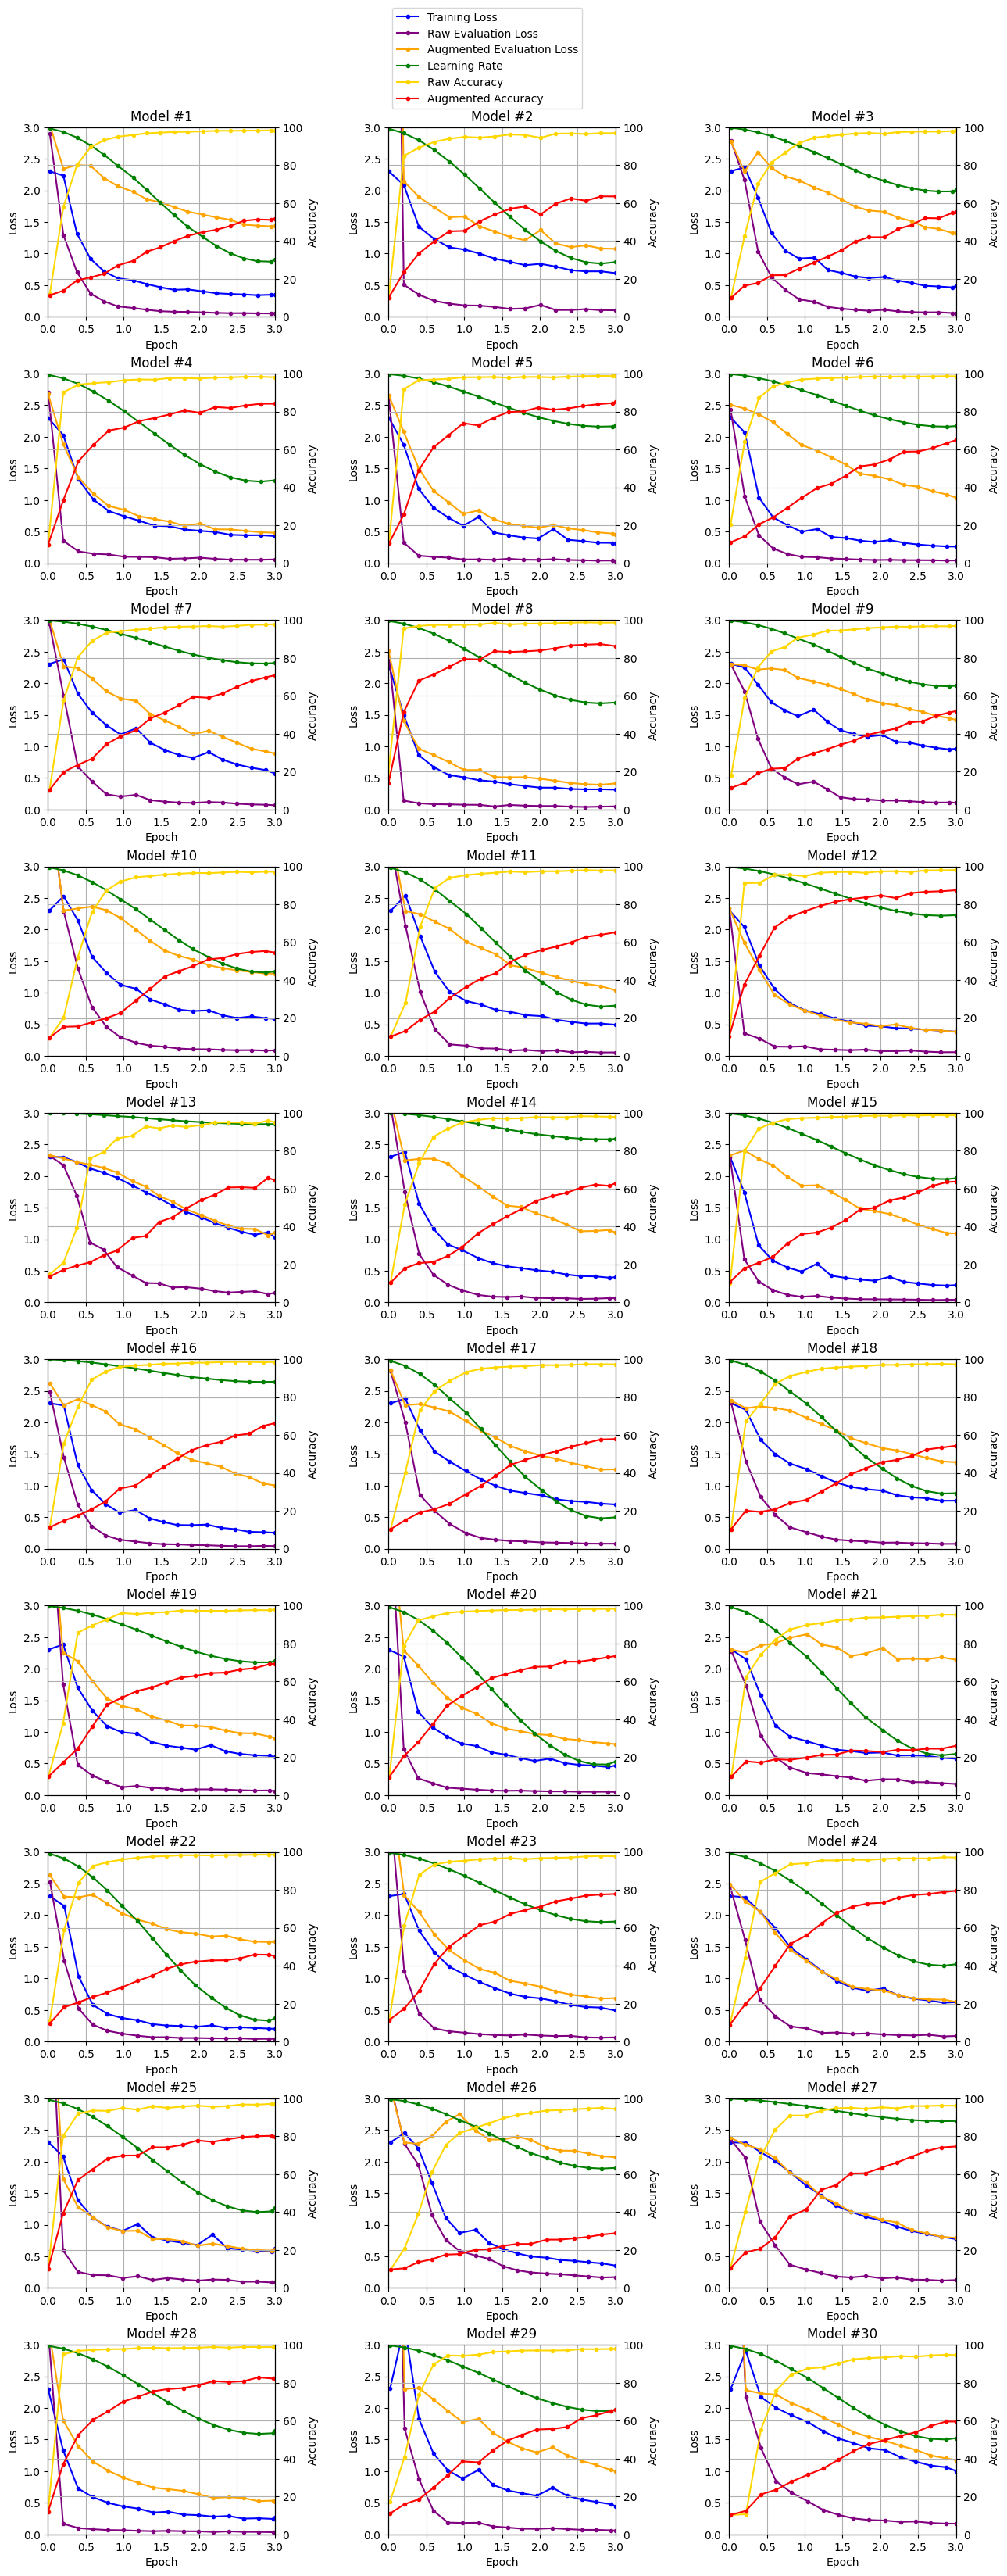

In [5]:
import os
from dotenv import load_dotenv

load_dotenv(".env", override=True)

MAX_BATCH_SIZE = int(os.getenv("MAX_BATCH_SIZE"))

results = random_search(
    ParamGrid(
        # smaller batch sizes perform better
        batch_size=range(1, MAX_BATCH_SIZE),
        sample_augmentation_ratio=[x * 0.1 for x in range(1, 10)],
        epochs=[3],
        # anything above 0.008 or below 0.0001 performs poorly
        starting_learning_rate=[x * 1e-4 for x in range(1, 80)],
        ending_learning_rate_ratio=[x * 0.01 for x in range(1, 100)],
        # performance degrades with higher weight decay
        weight_decay=[1e-3, 5e-4, 1e-4] + [x * 1e-5 for x in range(1, 10)],
        dropout=[x * 0.01 for x in range(1, 50)],
    ),
    max_trains=30,
)

### Finally, try to find correlations between the hyperparameters and the accuracy of each model

,Correlation with Harmonic Accuracy F1 Score
Sample Augmentation Ratio,0.617775
Dropout,0.284313
Ending LR,0.223013
Starting LR,0.130901
LR Difference,-0.008634
Weight Decay,-0.027568
Batch Size,-0.745285


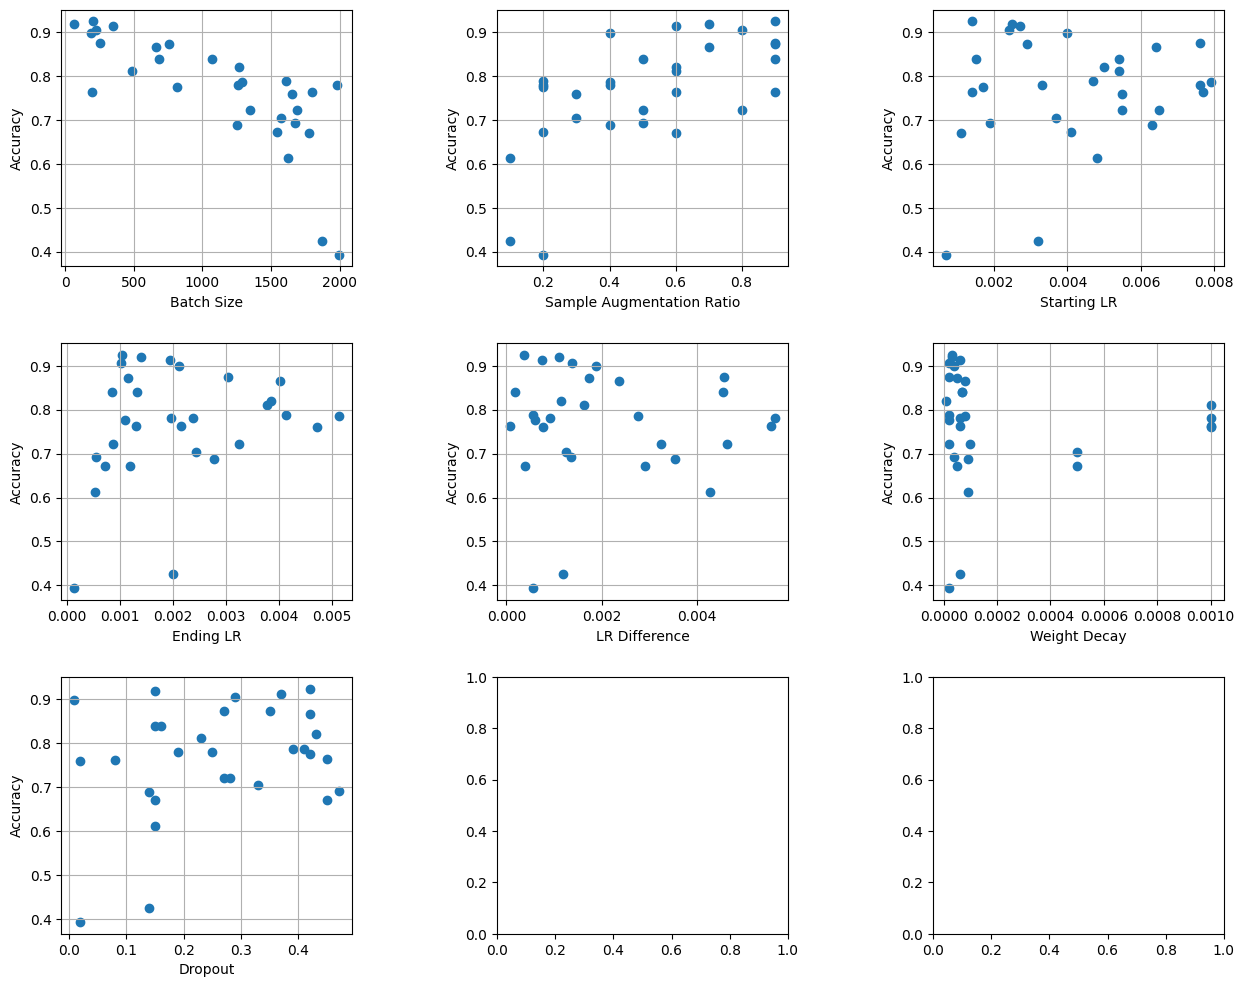

In [6]:
import statistics
hyperparameters = pd.DataFrame({
    'Model': [f'Model #{i + 1}' for i in range(len(results))],
    'Batch Size': [r.model_params.batch_size for r in results],
    # 'Samples Per Second': [r.samples_per_second for r in results],
    # 'Epochs': [r.model_params.epochs for r in results],
    'Sample Augmentation Ratio': [r.model_params.sample_augmentation_ratio for r in results],
    'Starting LR': [r.model_params.starting_learning_rate for r in results],
    'Ending LR': [r.model_params.starting_learning_rate * r.model_params.ending_learning_rate_ratio for r in results],
    'LR Difference': [r.model_params.starting_learning_rate - r.model_params.starting_learning_rate * r.model_params.ending_learning_rate_ratio for r in results],
    # 'Ending LR Ratio': [r.model_params.ending_learning_rate_ratio for r in results],
    'Weight Decay': [r.model_params.weight_decay for r in results],
    'Dropout': [r.model_params.dropout for r in results],
    # 'Training Loss': [r.train_loss for r in results],
    # 'Raw Eval Loss': [r.raw_eval_loss for r in results],
    # 'Augmented Eval Loss': [r.augmented_eval_loss for r in results],
    # 'Raw Accuracy': [f"{r.raw_accuracy}%" for r in results],
    # 'Augmented Accuracy': [f"{r.augmented_accuracy}%" for r in results],
    # 'Raw Precision': [r.raw_precision for r in results],
    # 'Augmented Precision': [r.augmented_precision for r in results],
    # 'Raw Recall': [r.raw_recall for r in results],
    # 'Augmented Recall': [r.augmented_recall for r in results],
    # 'Raw F1 Score': [r.raw_f1 for r in results],
    # 'Augmented F1 Score': [r.augmented_f1 for r in results],
    'Harmonic Accuracy F1 Score': [statistics.harmonic_mean([r.raw_f1, r.augmented_f1]) for r in results],
})
# Run a correlation analysis to see which parameters correlate most with the accuracy
correlation_matrix = hyperparameters.copy()
correlation_matrix.drop(columns=["Model"], inplace=True)
correlation_graph = pd.DataFrame(correlation_matrix.corr()["Harmonic Accuracy F1 Score"].sort_values(ascending=False))
correlation_graph = correlation_graph.drop(["Harmonic Accuracy F1 Score"], axis=0)
correlation_graph = correlation_graph.rename(columns={"Harmonic Accuracy F1 Score": "Correlation with Harmonic Accuracy F1 Score"})
display.display(correlation_graph)
correlation_matrix.drop(columns=["Harmonic Accuracy F1 Score"], inplace=True)

graph_height = 4
cols = 3
rows = math.ceil(len(correlation_matrix.columns) / cols)

plt.ion()
fig, axs = plt.subplots(rows, cols, figsize=(15, graph_height * rows))
if rows == 1:
    axs = axs.reshape(1, -1)
plt.subplots_adjust(wspace=0.5, hspace=0.3)

for i, param in enumerate(correlation_matrix.columns):
    if param == "Accuracy":
        continue
    ax = axs[i // cols, i % cols]
    ax.set_xlabel(param)
    ax.set_ylabel('Accuracy')
    ax.grid(True)
    ax.scatter(correlation_matrix[param], hyperparameters["Harmonic Accuracy F1 Score"])

### Analyzing Correlation Results
You can see from the correlation chart that having a **higher sample augmentation ratio** and a **lower batch size** were the two most important hyperparameters. The rest of the hyperparameters did not seem to have a significant impact on the accuracy of the model.

It seems that further experimentation is required! We could try to increase the number of models trained, or try to tweak new hyperparameters that we haven't tried yet. For example, we could expand the number of hyperparameters greatly by allowing the **model infrastructure** to be changed - number of layers, number of nodes per layer, kernel size and stride, etc. 

# What Next?
This was a example of how you can get closer to the best hyperparameter combination for your model. If you've run this notebook or the [Training Jupyter Notebook](./train.ipynb) on your own computer, your models will be saved to the `models` directory. You can test your models with handwritten numbers you draw yourself with the [Streamlit Demo](./demo.py)!

Run this command in the terminal to start the demo, and click on the link that appears:
```
make demo
```